# Naive Bayes

## References

1. https://doi.org/10.5281/zenodo.4322342
2. https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data

## Import Python Libraries

In [1111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.utils import resample

## Global Variables

In [1112]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [1113]:
# Sources: 
# 1. https://doi.org/10.5281/zenodo.4322342
# 2. https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m/data

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: CLIENTNUM: Unique identifier for each customer
# X02: Customer_Age: Age of customer
# X03: Gender: Gender of customer
# X04: Dependent_count: Number of dependents that the customer has
# X05: Education_Level: Education level of the customer
# X06: Marital_Status: Marital status of the customer
# X07: Income_Category: Income category of the customer
# X08: Card_Category: Type of card held by the customer
# X09: Months_on_book: How long the customer has been on the books
# X10: Total_Relationship_Count: Total number of relationships the customer has with the credit card provider
# X11: Months_Inactive_12_mon: Number of months the customer has been inactive in the last twelve months
# X12: Contacts_Count_12_mon: Number of contacts the customer has had in the last twelve months
# X13: Credit_Limit: Credit limit of the customer
# X14: Total_Revolving_Bal: Total revolving balance of the customer
# X15: Avg_Open_To_Buy: Average open-to-buy ratio of the customer
# X16: Total_Amt_Chng_Q4_Q1: Total amount changed from quarter 4 to quarter 1
# X17: Total_Trans_Amt: Total transaction amount
# X18: Total_Trans_Ct: Total transaction count
# X19: Total_Ct_Chng_Q4_Q1: Total count changed from quarter 4 to quarter 1
# X20: Avg_Utilization_Ratio: Average utilization ratio of the customer
# X21: Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1: Naive Bayes classifier for predicting whether or not someone will churn
# X22: Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2: Naive Bayes classifier for predicting whether or not someone will churn
#   y: Attrition_Flag: Flag indicating whether or not the customer has churned out


In [1114]:
# load heart.csv dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/bank_churners.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [1115]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'Attrition_Flag'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [1116]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,y,X02,X03,X04,X05,X06,X07,X08,X09,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [1117]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     10127 non-null  int64  
 1   y       10127 non-null  object 
 2   X02     10127 non-null  int64  
 3   X03     10127 non-null  object 
 4   X04     10127 non-null  int64  
 5   X05     10127 non-null  object 
 6   X06     10127 non-null  object 
 7   X07     10127 non-null  object 
 8   X08     10127 non-null  object 
 9   X09     10127 non-null  int64  
 10  X10     10127 non-null  int64  
 11  X11     10127 non-null  int64  
 12  X12     10127 non-null  int64  
 13  X13     10127 non-null  float64
 14  X14     10127 non-null  int64  
 15  X15     10127 non-null  float64
 16  X16     10127 non-null  float64
 17  X17     10127 non-null  int64  
 18  X18     10127 non-null  int64  
 19  X19     10127 non-null  float64
 20  X20     10127 non-null  float64
 21  X21     10127 non-null  float64
 22

In [1118]:
# describe data
df1.describe()

,X01,X02,X04,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


In [1119]:
# check missing values
df1.count()

X01    10127
y      10127
X02    10127
X03    10127
X04    10127
X05    10127
X06    10127
X07    10127
X08    10127
X09    10127
X10    10127
X11    10127
X12    10127
X13    10127
X14    10127
X15    10127
X16    10127
X17    10127
X18    10127
X19    10127
X20    10127
X21    10127
X22    10127
dtype: int64

## Data Cleaning

In [1120]:
# drop useless columns
drop_id = ['X01', 'X21', 'X22']
df1 = df1.drop(columns = drop_id, errors = 'ignore')

df1.head()

,y,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Transform Dataset

In [1122]:
# response column
y_col = new_y_col
y_col

'y'

In [1123]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20'],
      dtype='object')

In [1124]:
# get unique y_labels
y_labels = ['Existing Customer','Attrited Customer']
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'Existing Customer': 0, 'Attrited Customer': 1}

In [1125]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,y,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [1126]:
# encode categorical values to numerical values
le = LabelEncoder()

categorical_cols = df1[X_cols].select_dtypes("object").columns
df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

df1.head()

,y,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,0,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,0,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,0,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,0,40,0,4,3,3,4,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,0,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [1127]:
# check label distribution
temp = list(y_labels.values())
cond1 = df1.y == temp[0]
cond2 = df1.y == temp[1]

n_1 = np.sum(cond1)
print(temp[0])
print(n_1)

n_2 = np.sum(cond2)
print(temp[1])
print(n_2)

# upsample minority label
df_temp = df1.loc[cond2,:]
n_diff = n_1 - n_2
print(n_diff)

df_upsample = resample(
  df_temp,
  replace = True,
  n_samples = n_diff,
  random_state = random_state
)

# update df1
df1 = pd.concat([df1, df_upsample], ignore_index = True)
df1.info()

0
8500
1
1627
6873
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       17000 non-null  int64  
 1   X02     17000 non-null  int64  
 2   X03     17000 non-null  int32  
 3   X04     17000 non-null  int64  
 4   X05     17000 non-null  int32  
 5   X06     17000 non-null  int32  
 6   X07     17000 non-null  int32  
 7   X08     17000 non-null  int32  
 8   X09     17000 non-null  int64  
 9   X10     17000 non-null  int64  
 10  X11     17000 non-null  int64  
 11  X12     17000 non-null  int64  
 12  X13     17000 non-null  float64
 13  X14     17000 non-null  int64  
 14  X15     17000 non-null  float64
 15  X16     17000 non-null  float64
 16  X17     17000 non-null  int64  
 17  X18     17000 non-null  int64  
 18  X19     17000 non-null  float64
 19  X20     17000 non-null  float64
dtypes: float64(5), int32(5), int64(10)
memory usage: 2.3 

In [1128]:
# # check label distribution
# temp = list(y_labels.values())
# cond1 = df1.y == temp[0]
# cond2 = df1.y == temp[1]

# n_1 = np.sum(cond1)
# print(temp[0])
# print(n_1)

# n_2 = np.sum(cond2)
# print(temp[1])
# print(n_2)

# # downsample majority label
# df_temp = df1.loc[cond1,:]
# n_diff = n_1 - n_2
# print(n_diff)

# df_upsample = resample(
#   df_temp,
#   replace = False,
#   n_samples = n_diff,
#   random_state = random_state
# )

# # # update df1
# df1 = df1.drop(df_upsample.index)
# df1.info()

In [1129]:
# normalize all X_cols
df2 = df1.copy()
# norm = StandardScaler()
# norm = MinMaxScaler()
norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,y,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,0,-0.090909,1.0,0.5,0.000000,0.0,-0.5,0.0,0.375,0.666667,-2.0,0.0,1.026729,-0.100234,1.040744,2.372093,-0.596848,-0.303030,3.371134,-0.092637
1,0,0.272727,0.0,1.5,-0.333333,1.0,0.5,0.0,1.000,1.000000,-2.0,-1.0,0.479822,-0.049238,0.482934,3.170543,-0.539986,-0.575758,10.549828,0.011876
2,0,0.454545,1.0,0.5,-0.333333,0.0,0.0,0.0,0.000,0.333333,-2.0,-3.0,-0.116780,-0.555686,-0.007278,7.251938,-0.309448,-0.969697,5.804124,-0.237530
3,0,-0.545455,0.0,1.0,0.000000,2.0,0.5,0.0,-0.250,0.000000,1.0,-2.0,-0.129728,0.919695,-0.330714,2.643411,-0.586404,-0.969697,5.804124,1.567696
4,0,-0.545455,1.0,0.5,0.666667,0.0,-0.5,0.0,-1.875,0.666667,-2.0,-3.0,0.043284,-0.555686,0.152837,5.627907,-0.723721,-0.727273,6.378007,-0.237530


In [1130]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

In [1131]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,0,X02,-0.090909
1,0,X02,0.272727
2,0,X02,0.454545
3,0,X02,-0.545455
4,0,X02,-0.545455


## Visualize Dataset

In [1132]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (15, 15)

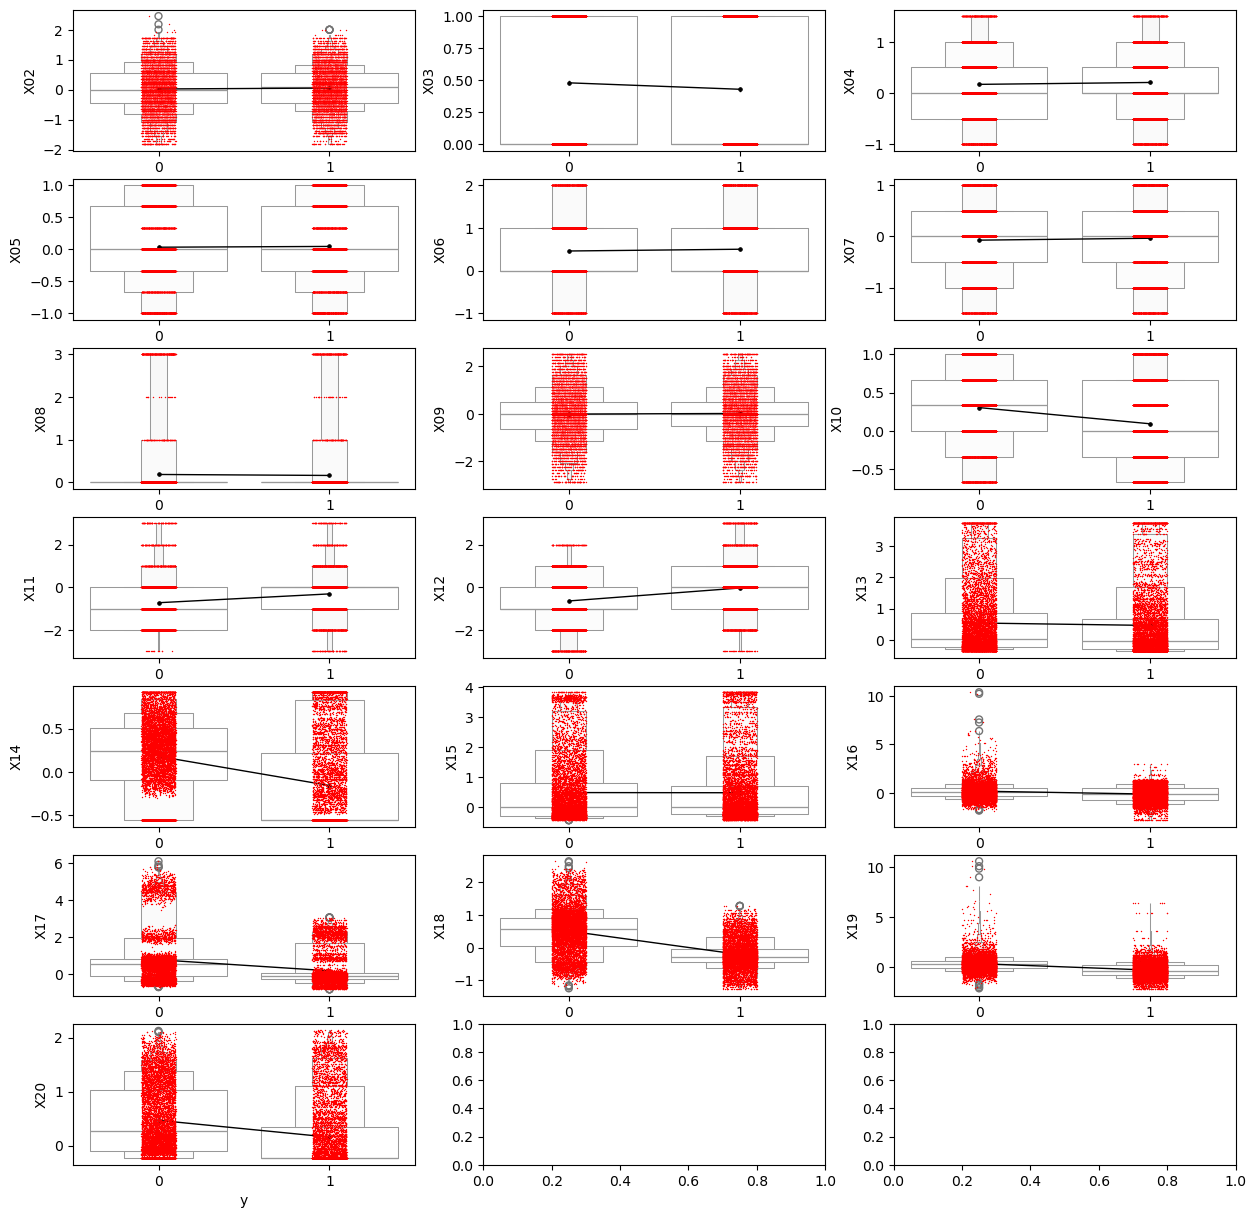

In [1133]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Remove Features Having % Similar Values or More

In [1134]:
# porportion similar (p)
p = 1
# porportion dissimilar (q = 1- p)
q = 1 - p

print(p,q)

1 0


In [1135]:
# initialize variance threshold model (based on porportion dissimilar)
myfit = VarianceThreshold(q)

In [1136]:
# fit model
temp = myfit.fit_transform(df2[X_cols])
temp.shape

(17000, 19)

In [1137]:
# get columns that have at least p-similar or q-disimilar values
X_cols_var_threshold = myfit.get_feature_names_out()
X_cols_var_threshold

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20'], dtype=object)

In [1138]:
# update X_cols
X_cols = X_cols_var_threshold
X_cols

array(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       'X20'], dtype=object)

### Select Features Using Model Selection Methods

In [1139]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [1140]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 4,
  # max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [1141]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [1142]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.02843245, 0.00396558, 0.01308592, 0.00957123, 0.00748751,
       0.01059507, 0.00103891, 0.01767208, 0.03566369, 0.02436738,
       0.01579139, 0.03670122, 0.15679175, 0.02266856, 0.06451755,
       0.21982796, 0.22392051, 0.08760948, 0.02029175])

In [1143]:
# threshold feature importance
# feature_importance_threshold = np.mean(feature_importance)
feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.75)
feature_importance_threshold

0.022668558243438244

In [1144]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [1145]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [1146]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X02', 'X10', 'X11', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18',
       'X19'], dtype=object)

## Train and Test ML Model

In [1163]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

10
['X02' 'X10' 'X11' 'X13' 'X14' 'X15' 'X16' 'X17' 'X18' 'X19']


In [1164]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  stratify = y, shuffle = True, 
  train_size = 0.7, random_state = random_state
)

In [1165]:
# initialize Decision Tree model
myfit = GaussianNB()

In [1166]:
# fit model
temp = myfit.fit(X_train, y_train)

In [1167]:
# get predictions on test data
y_hat = myfit.predict(X_test)

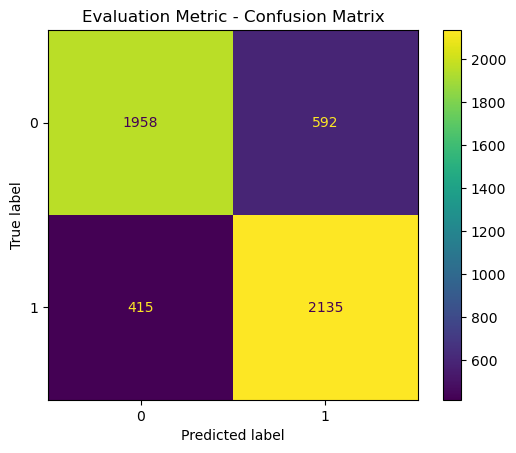

In [1168]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [1169]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      2550
           1       0.78      0.84      0.81      2550

    accuracy                           0.80      5100
   macro avg       0.80      0.80      0.80      5100
weighted avg       0.80      0.80      0.80      5100



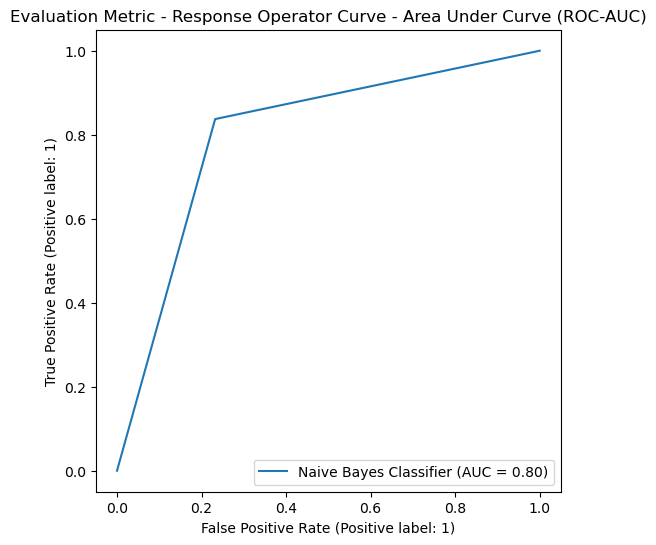

In [1170]:
# model evaluation - AUC
fig, ax = plt.subplots(figsize = (6, 6))
RocCurveDisplay.from_predictions(ax = ax, 
  y_true = y_test, y_pred = y_hat, pos_label = 1,
  name = "Naive Bayes Classifier"
)
plt.title('Evaluation Metric - Response Operator Curve - Area Under Curve (ROC-AUC)')
plt.show()